# **NLP-Text classfication - Logistic Reggresion from scratch**
Youssef Elraggal 7806

Mohamed Ossama    7861

---



#**Logistic reggresion**

* **Training phase** : we will learn the weights W & b using SGD (to find optimal weights) and CrossEntropyLoss (to measure how good are the weights)  
* **Testing phase**: Given X , we will compute the P(Y|X) for each possible class Y , using the learned weights W & b

##**Imports**

In [52]:
# !pip install datasets

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

##**Load Training and Testing Data**

Training data is a series of (X,Y) pairs,we will represent each X by a feature vector [X1,X2,X3,.....,XN]


In [54]:
from datasets import load_dataset
dataset = load_dataset("sst", "default")

In [55]:
x_train, y_train = np.array(dataset['train']['sentence']), np.array(dataset['train']['label'])
x_test, y_test = np.array(dataset['test']['sentence']), np.array(dataset['test']['label'])

##**Extract features from Training Data**

In [56]:
# Function to generate bigrams from a sentence
def generate_bi(sentence):
    words = ["<s>"] +  sentence.lower().split() + ["<s>"]
    return np.array([list(words[i:i+2]) for i in range(len(words)-1)]) # (<S> ,eat),(eat , food)....

# Generate bigrams from the dataset
all_bigrams = [bigram for sentence in x_train for bigram in generate_bi(sentence)]

# Get unique bigrams
unique_bigrams = np.unique(all_bigrams, axis = 0)

# Create a mapping of unique bigrams to indices
bigram_to_index = {tuple(bigram): idx for idx, bigram in enumerate(unique_bigrams)}

# print(len(bigram_to_index))
# print(bigram_to_index)

# For memory optimization
del unique_bigrams
del all_bigrams

## **Mapping Values to Classes**


In [57]:
def map_to_classes(arr):
  for i, lable in enumerate(arr):
    if lable <= 0.2:
      arr[i] = 0
    elif lable <= 0.4:
      arr[i] = 1
    elif lable <= 0.6:
      arr[i] = 2
    elif lable <= 0.8:
      arr[i] = 3
    elif lable <= 1:
      arr[i] = 4

In [58]:
map_to_classes(y_train)
map_to_classes(y_test)

# For memory optimization
# Note: the smallest dtypr in python is int8 , boolean is also 8 bit representaion
y_train = y_train.astype(np.int8)
y_test = y_test.astype(np.int8)
print(y_train)

[3 4 3 ... 3 0 1]


## **build feature vector for each input value X**

In [59]:
def build_feature_vector_for_each_input_x (sentence) :
  row  = np.zeros(len(bigram_to_index), dtype=np.int8)
  chs = ['<s>'] + sentence.lower().split() + ['<s>']
  for w1, w2 in zip(chs, chs[1:]): # w1 wil start from chs  ,  w2 wil start from chs [1] till end
    if (w1,w2) in bigram_to_index:
      row[bigram_to_index[(w1, w2)]] = 1
  return  row
x = build_feature_vector_for_each_input_x("The Rock is destined to be the 21st Century 's new `` Conan")
print(np.sum(x == 1))
print(x)

13
[0 0 0 ... 0 0 0]


## **Start Training phase**
### Implementing the pseudo code of Logistic regression
  pseudo codes -- from [here](https://web.stanford.edu/~jurafsky/slp3/5.pdf)

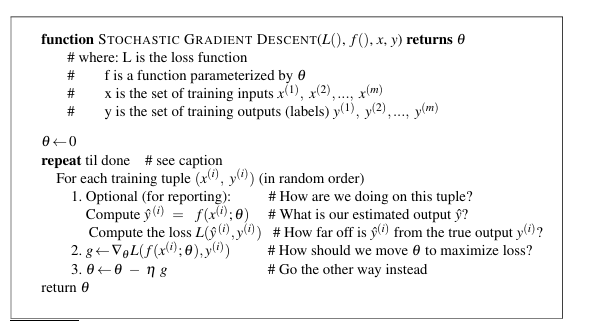

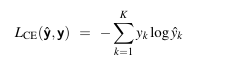
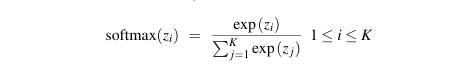
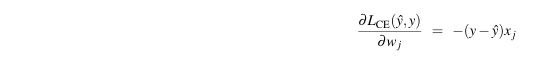

 Function f : Z= WX + b  ||  K :classes (5)||  F :features (bigrams)
                    
 Y (prediction)-->  K x 1

 W (theta)     -->  K x F

 X (input)     -->  F x 1

 b (baias)     -->  K x 1

**Implement function to update weights**

[outer product explanataion](https://en.wikipedia.org/wiki/Outer_product)

In [60]:
# Dimensions      kx1         kxf  kx1 fx1
def updateWeights(Y_predicted,w   ,y  ,x,  lr, b):
    # y is the true lable vector [0 1 0 0 0]
    cost = Y_predicted - y  # dimension of cost kx1
    dw = np.outer(cost, x)  # dimension of dw   kx1 * fx1  == kxf
    db = cost
    new_w  = w - lr * dw
    new_b = b - lr * db
    return new_w, new_b

**Intialize the weight , baias**

In [61]:
np.random.seed(42)
learning_rate = 0.01
epochs = 1

k = 5
f = len(bigram_to_index)

#intialize W & b with zeros , float128 (high precision) to avoid NAN values while training
W = np.zeros((k, f)).astype(np.float128) # W
W.shape

b = np.zeros( (k, 1) ).astype(np.float128) # b
b.shape

(5, 1)

**start training**

In [62]:
for epoch in range(epochs): # 1 epoch means (1 iter through all the data)
    shuffled_indeces = np.random.permutation(range(x_train.shape[0])) # .shape[0] --> number of rows

    for idx in shuffled_indeces: # for each training tuble in random order
        X_i_features = build_feature_vector_for_each_input_x(x_train[idx]).T.reshape(-1, 1) # build_feature_vector_for_each_input_x returns a row of features 1xF

        # 1) Compute Y'
        # calculate Z score (Z_dimensions) --> K x 1
        z=np.dot(W,X_i_features)+b

        # softmax function(to predict y)
        epsilon = 1e-6  # if we make e(-50 000) ==> nan (l2no rkm soghyr awy)(from stackover flow)  , as e(-inf)=0
        exps = np.nan_to_num(np.exp(z)) + epsilon  # nan to number (changes nan with zeros)
        exp_sums = np.sum(exps) # sum the numbers in the given vctor
        estimated_Y= exps / exp_sums

        # 2) compute the loss   (- z log s) == > z=1 or 0   , s : estimated
        # calcuate cross entroyloss
        true_label_vector = np.zeros((5,1))
        true_label_vector[y_train[idx]] = 1 #[0 1 0 0 0]  if the true label is from second class

        epsilon = 1e-6  #we will add epsilon (really small number) to estimated_Y before taking the log to avoid estimated_Y being 0
        loss = -np.sum(np.log(estimated_Y + epsilon) * true_label_vector)

        # Check for NaN values
        if np.isnan(W).any():
            raise Exception("There is Nan")

        # 3) Graidient step
        # Update weights w & b
        # Dimensions        k x 1        kxf  kx1               fx1
        W,b = updateWeights(estimated_Y, W   ,true_label_vector, X_i_features, learning_rate, b)

        # for memory optimization
        del X_i_features
        del estimated_Y
        del z
# check for nan values
np.any(np.isnan(W))

False

## **Testing phase**

In [63]:
predicted_labbles_array = np.zeros(y_test.shape)
for i, sentence in enumerate(x_test):
    x = build_feature_vector_for_each_input_x(sentence).T.reshape(-1, 1)

    # 1) Compute Y'
    # calculate Z score (Z_dimensions) --> K x 1
    z=np.dot(W,x)+b

    # softmax function(to predict y)
    epsilon = 1e-6  # if we make e(-50 000) ==> nan (l2no rkm soghyr awy)(from stackover flow)  , as e(-inf)=0
    exps = np.nan_to_num(np.exp(z)) + epsilon  # nan to number (changes nan with zeros)
    exp_sums = np.sum(exps)
    estimated_Y= exps / exp_sums

    idx_predicted_class = np.argmax(estimated_Y)
    predicted_labbles_array[i] = idx_predicted_class

    del x
    del estimated_Y
    del idx_predicted_class
np.any(np.isnan(W))

False

In [64]:
print("Accuracy")
print(np.mean(predicted_labbles_array.astype(np.int8) == y_test))
# print(y_test.dtype)

Accuracy
0.34479638009049773


# **Comparison with scikit learn**


**prepare data** ( x-train , y-train , x-test . y-test)

In [65]:
# prepare input X
x_train = np.array([build_feature_vector_for_each_input_x(sentence).T.reshape(-1, 1) for sentence in x_train])
print(x_train.dtype)
print("x train dimensions:")
print(x_train.shape)
x_train = x_train.reshape(8544, 86500)
print("x train dimensions after reshape:")
x_train.shape

# CHECK for input labels Y (check that we already run map to clasess function)
print(" Y-train :")
y_train[:5]

print(" X-test dimension:")
x_test.shape

int8
x train dimensions:
(8544, 86500, 1)
x train dimensions after reshape:
 Y-train :
 X-test dimension:


(2210,)

##**sklearn.linear_model.SGDClassifier**
[check parameters](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)

In [66]:
from sklearn.linear_model import SGDClassifier
# Instantiate a SGDClassifier model with parameters consistent with those used in the custom-built model.
# The model is configured with logistic loss, no regularization penalty, one epoch of training, no tolerance for stopping criteria, constant learning rate with an initial step size of 0.01, data shuffling during training, and a fixed random state for reproducibility.
SGD_model = SGDClassifier(loss='log_loss', penalty=None, max_iter=1, tol=None, learning_rate='constant', eta0=0.01, shuffle=True, random_state=42)

# Fit the model to the training data.
SGD_model.fit(x_train, y_train)

y_pred = SGD_model.predict(np.array([build_feature_vector_for_each_input_x(sentence).T.reshape(-1, 1) for sentence in x_test]).reshape(2210, 86500))

accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)


Accuracy: 0.33710407239819007


## **sklearn.linear_model.LogisticRegression**
[check parameters](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

logisticRegression_model = LogisticRegression(penalty=None, multi_class="multinomial")
logisticRegression_model.fit(x_train, y_train)

predictions = logisticRegression_model.predict(np.array([build_feature_vector_for_each_input_x(sentence).T.reshape(-1, 1) for sentence in x_test]).reshape(2210, 86500))

# Evaluate the model
accuracy = np.mean(predictions == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.32986425339366515


## **Part 3 - our implementation to confusion matrix , precison, recall,and f1**

In [68]:
def confusion_matrixx(y_true, y_pred,num_classes):
    # Initialize confusion matrix
    conf_mat = np.zeros((num_classes, num_classes), dtype=int)

    # Fill confusion matrix
    for true, pred in zip(y_true, y_pred):
        conf_mat[int(true), int(pred)] += 1

    return conf_mat

def precision_recall_f1(conf_mat):
    num_classes = conf_mat.shape[0]
    precision = np.zeros(num_classes, dtype=float)
    recall = np.zeros(num_classes, dtype=float)
    f1_scorez = np.zeros(num_classes, dtype=float)

    for i in range(num_classes):
        true_positive = conf_mat[i, i]
        false_positive = np.sum(conf_mat[:, i]) - true_positive
        false_negative = np.sum(conf_mat[i, :]) - true_positive

        precision[i] = true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0
        recall[i] = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
        f1_scorez[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else 0

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1_score = np.mean(f1_scorez)

    return precision, recall, f1_scorez, macro_precision, macro_recall, macro_f1_score

 # **Confusion Matrix & Evaluation Metrics**

##**Logistic regression from scratch**

In [70]:
print("our implemention of logistic regression from scratch")

print("our function")
conf_mat = confusion_matrixx(y_test, predicted_labbles_array, 5)
precision, recall, f1_scores, macro_precision, macro_recall, macro_f1_score = precision_recall_f1(conf_mat)

print("Confusion Matrix:")
print(conf_mat)
print("\nPrecision per class:", precision)
print("Recall per class:", recall)
print("F1 Score per class:", f1_scores)
print("\nMacro-averaged Precision:", macro_precision)
print("Macro-averaged Recall:", macro_recall)
print("Macro-averaged F1 Score:", macro_f1_score)

print("-------------------------------------------------------------------------------------------------------------------")
print("sklearn function")

cm = confusion_matrix(y_test, predicted_labbles_array)
print("Confusion matrix:",cm)

precisions = precision_score(y_test, predicted_labbles_array, average=None)
recalls = recall_score(y_test, predicted_labbles_array, average=None)
f1_scoress = f1_score(y_test, predicted_labbles_array, average=None)
# Convert to list
precision_list = precisions.tolist()
recall_list = recalls.tolist()
f1_list = f1_scoress.tolist()

print("Precision per class:", precision_list)
print("Recall per class:", recall_list)
print("F1 Score per class:", f1_list)


macro_precision = precision_score(y_test, predicted_labbles_array, average='macro')
macro_recall = recall_score(y_test, predicted_labbles_array, average='macro')
macro_f1 = f1_score(y_test, predicted_labbles_array, average='macro')

print("Macro-averaged Precision:", macro_precision)
print("Macro-averaged Recall:", macro_recall)
print("Macro-averaged F1 Score:", macro_f1)

our implemention of logistic regression from scratch
our function
Confusion Matrix:
[[  0 191   1  85   2]
 [  0 423   8 200   2]
 [  0 231   6 151   1]
 [  0 181   9 318   2]
 [  0 143   3 238  15]]

Precision per class: [0.         0.36184773 0.22222222 0.32056452 0.68181818]
Recall per class: [0.         0.66824645 0.01542416 0.62352941 0.03759398]
F1 Score per class: [0.         0.46947836 0.02884615 0.42343542 0.07125891]

Macro-averaged Precision: 0.31729053065493085
Macro-averaged Recall: 0.2689588013498328
Macro-averaged F1 Score: 0.19860376760620163
-------------------------------------------------------------------------------------------------------------------
sklearn function
Confusion matrix: [[  0 191   1  85   2]
 [  0 423   8 200   2]
 [  0 231   6 151   1]
 [  0 181   9 318   2]
 [  0 143   3 238  15]]
Precision per class: [0.0, 0.3618477331052181, 0.2222222222222222, 0.32056451612903225, 0.6818181818181818]
Recall per class: [0.0, 0.6682464454976303, 0.01542416452442

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **SGD Classifier**

In [71]:
print("our implemention of logistic regression from scratch")

print("our function")
conf_mat = confusion_matrixx(y_test, y_pred, 5)
precision, recall, f1_scoree, macro_precision, macro_recall, macro_f1_score = precision_recall_f1(conf_mat)

print("Confusion Matrix:")
print(conf_mat)
print("\nPrecision per class:", precision)
print("Recall per class:", recall)
print("F1 Score per class:", f1_scoree)
print("\nMacro-averaged Precision:", macro_precision)
print("Macro-averaged Recall:", macro_recall)
print("Macro-averaged F1 Score:", macro_f1_score)

print("-------------------------------------------------------------------------------------------------------------------")
print("sklearn function")

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:",cm)

precisions = precision_score(y_test, y_pred, average=None)
recalls = recall_score(y_test, y_pred, average=None)
f1_scores = f1_score(y_test, y_pred, average=None)
# Convert to list
precision_list = precisions.tolist()
recall_list = recalls.tolist()
f1_list = f1_scores.tolist()

print("Precision per class:", precision_list)
print("Recall per class:", recall_list)
print("F1 Score per class:", f1_list)


macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Macro-averaged Precision:", macro_precision)
print("Macro-averaged Recall:", macro_recall)
print("Macro-averaged F1 Score:", macro_f1)

our implemention of logistic regression from scratch
our function
Confusion Matrix:
[[  0 206   0  72   1]
 [  0 479   1 152   1]
 [  0 268   4 116   1]
 [  0 256   3 249   2]
 [  0 192   0 194  13]]

Precision per class: [0.         0.34189864 0.5        0.31800766 0.72222222]
Recall per class: [0.         0.75671406 0.01028278 0.48823529 0.03258145]
F1 Score per class: [0.         0.47099312 0.02015113 0.38515081 0.06235012]

Macro-averaged Precision: 0.37642570577666196
Macro-averaged Recall: 0.25756271682658843
Macro-averaged F1 Score: 0.18772903649622347
-------------------------------------------------------------------------------------------------------------------
sklearn function
Confusion matrix: [[  0 206   0  72   1]
 [  0 479   1 152   1]
 [  0 268   4 116   1]
 [  0 256   3 249   2]
 [  0 192   0 194  13]]
Precision per class: [0.0, 0.3418986438258387, 0.5, 0.31800766283524906, 0.7222222222222222]
Recall per class: [0.0, 0.7567140600315956, 0.010282776349614395, 0.488235

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **sklearn.linear_model.LogisticRegression**

In [74]:
print("our implemention of logistic regression from scratch")

print("our function")
conf_mat = confusion_matrixx(y_test, predictions, 5)
precision, recall, f1_scoreee, macro_precision, macro_recall, macro_f1_score = precision_recall_f1(conf_mat)

print("Confusion Matrix:")
print(conf_mat)
print("\nPrecision per class:", precision)
print("Recall per class:", recall)
print("F1 Score per class:", f1_scoreee)
print("\nMacro-averaged Precision:", macro_precision)
print("Macro-averaged Recall:", macro_recall)
print("Macro-averaged F1 Score:", macro_f1_score)

print("-------------------------------------------------------------------------------------------------------------------")
print("sklearn function")

cm = confusion_matrix(y_test, predictions)
print("Confusion matrix:",cm)

precisions = precision_score(y_test, predictions, average=None)
recalls = recall_score(y_test, predictions, average=None)
f1_scores = f1_score(y_test, predictions, average=None)
# Convert to list
precision_list = precisions.tolist()
recall_list = recalls.tolist()
f1_list = f1_scores.tolist()

print("Precision per class:", precision_list)
print("Recall per class:", recall_list)
print("F1 Score per class:", f1_list)


macro_precision = precision_score(y_test, predictions, average='macro')
macro_recall = recall_score(y_test, predictions, average='macro')
macro_f1 = f1_score(y_test, predictions, average='macro')

print("Macro-averaged Precision:", macro_precision)
print("Macro-averaged Recall:", macro_recall)
print("Macro-averaged F1 Score:", macro_f1)

our implemention of logistic regression from scratch
our function
Confusion Matrix:
[[ 65 106  43  38  27]
 [ 89 246 115 150  33]
 [ 35 123  68 131  32]
 [ 29 100  72 227  82]
 [ 20  41  45 170 123]]

Precision per class: [0.27310924 0.39935065 0.19825073 0.31703911 0.41414141]
Recall per class: [0.23297491 0.38862559 0.1748072  0.44509804 0.30827068]
F1 Score per class: [0.25145068 0.39391513 0.18579235 0.37030995 0.35344828]

Macro-averaged Precision: 0.3203782284395535
Macro-averaged Recall: 0.30995528333243744
Macro-averaged F1 Score: 0.310983277147496
-------------------------------------------------------------------------------------------------------------------
sklearn function
Confusion matrix: [[ 65 106  43  38  27]
 [ 89 246 115 150  33]
 [ 35 123  68 131  32]
 [ 29 100  72 227  82]
 [ 20  41  45 170 123]]
Precision per class: [0.27310924369747897, 0.39935064935064934, 0.19825072886297376, 0.3170391061452514, 0.41414141414141414]
Recall per class: [0.23297491039426524, 0.38

**Note :: After implementing my version of logistic regression, I compared it with scikit-learn's implementations, specifically `SGDClassifier` and `LogisticRegression`. In my analysis, I found that `LogisticRegression` from scikit-learn is better suited when dealing with sparse feature matrices. This is because `LogisticRegression` does not rely on the gradient descent optimizer, which can be inefficient with sparse matrices due to its dense gradient computation. Instead, `LogisticRegression` uses optimization techniques like coordinate descent or Limited-memory BFGS (L-BFGS), which perform better in such scenarios. On the other hand, `SGDClassifier` from scikit-learn is comparable to my implementation. Despite its name suggesting stochastic gradient descent, after parameter assignment, it can utilize various optimization algorithms, including gradient descent, similar to how I've implemented it. Therefore, `SGDClassifier` is a suitable alternative when flexibility in optimization methods is desired, making it comparable to my implementation.**
